# WIP

In [2]:
%pylab inline
import webbpsf
import astropy.io.fits as fits
import scipy.ndimage

import os
import sys
import mirage_ote_utils

webbpsf.setup_logging('none')

Populating the interactive namespace from numpy and matplotlib
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-034 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-039
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


Need mirror states for OTE-18 through OTE-23
   OTE-18: obs 6  
      /ifs/jwst/tel/TeamPractices/OTE-18/output/saved_states/ote_state_OTE-18_1155_Obs6_final.txt
   OTE-19: obs 1  
      /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/ote_state_OTE-19_1156_Obs1_final.txt
   OTE-21: obs 6, 8
      /ifs/jwst/tel/TeamPractices/OTE-21/output/saved_state/ote_state_OTE-21_1158_Obs6_final.txt 
      /ifs/jwst/tel/TeamPractices/OTE-21/output/saved_state/ote_state_OTE-21_1158_Obs8_final.txt
   OTE-22: obs 3 
      /ifs/jwst/tel/TeamPractices/OTE-22/output/saved_states/ote_state_OTE-22_1159_Obs3_final.txt
   OTE-23: obs 2, 4
      /ifs/jwst/tel/TeamPractices/OTE-23/output/saved_states/ote_state_OTE-23_1160_Obs2_final.txt
      /ifs/jwst/tel/TeamPractices/OTE-23/output/saved_states/ote_state_OTE-23_1160_Obs4_final.txt

In [56]:
npix=1024

In [57]:
if npix != 1024:
    pupilopd = f'/ifs/jwst/tel/TeamPractices/FGS_data_files/OPD_RevW_ote_for_FGS_predicted_npix{npix}.fits'
else: 
    pupilopd = 'OPD_RevW_ote_for_FGS_predicted.fits'

## OTE-18 

In [61]:
OTEnumber = 'OTE-18'
prop_id = 1155
obs = 6

In [62]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-16/output/saved_states/phase_post_ote16_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-18/output/saved_states/ote_state_OTE-18_1155_Obs6_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    22.0899    -0.8804    -2.3363   364.4666  -300.1478     0.1774
A2	    -0.4103     1.7103    -3.7910  -104.1853    62.7415     0.2866
A3	   -33.9908     2.5869     3.1181  -101.8679   569.9164     0.1054
A4	   -25.1863     0.8158     2.2120   371.6188   398.5599    -0.1006
A5	    -3.9443    -1.6895     2.3195  -227.2394    54.1420     0.0200
A6	    14.7034    -2.5781     2.2911  -296.9655  -213.8277     0.2304
B1	   -75.2246     1.3833    -4.0091   178.1203 -1196.9810     0.2681
C1	    -0.0552    77.4931    -4.9239   -70.5283 -1199.8558     0.2750
B2	   -56.6127    -0.9349    -5.5349   -25.5233  -851

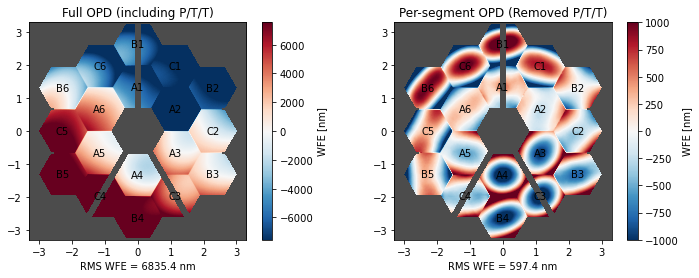

In [64]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-16/output/saved_states/phase_post_ote16_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [65]:
# Just create the PSF from this saved state, don't move mirrors or anything

jitter = 0.020   # arcseconds, radial. E.g. = 0.009 is 9 mas
                 # 20 mas is the value appropriate for TRACK in GA
                 # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning
                    

instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library', 
                           f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-18/output/gridded_psf_library/OTE-18-1155/Observation006/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-18/output/gridded_psf_library/OTE-18-1155/Observation006/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## OTE-19

In [66]:
OTEnumber = 'OTE-19'
prop_id = 1156
obs = 1

In [67]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-16/output/saved_states/phase_post_ote16_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/ote_state_OTE-19_1156_Obs1_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    25.9469    -3.3985    -1.4412   364.4666  -300.1478     0.1774
A2	     3.7072     3.7976    -3.8755  -104.1853    62.7415     0.2866
A3	   -33.7337     7.1230     2.1532  -101.8679   569.9164     0.1054
A4	   -28.8788     3.2459     2.0676   371.6188   398.5599    -0.1006
A5	    -7.9788    -3.7222     3.0608  -227.2394    54.1420     0.0200
A6	    14.4529    -7.2039     2.0154  -296.9655  -213.8277     0.2304
B1	   -79.1032     3.9589    -4.7081   178.1203 -1196.9810     0.2681
C1	     0.2058    82.1077    -4.9479   -70.5283 -1199.8558     0.2750
B2	   -60.7258    -3.0506    -4.6731   -25.5233  -851

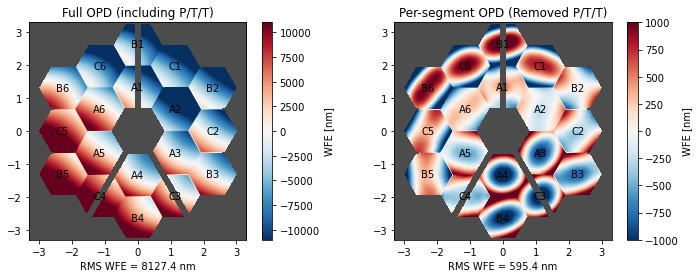

In [68]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-16/output/saved_states/phase_post_ote16_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [69]:
jitter = 0.020    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning

instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library', 
                           f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01" )

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-19/output/gridded_psf_library/OTE-19-1156/Observation001/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-19/output/gridded_psf_library/OTE-19-1156/Observation001/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## OTE-21

## obs 6 

In [70]:
OTEnumber = 'OTE-21'
prop_id = 1158
obs = 6

In [71]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-21/output/saved_states/ote_state_OTE-21_1158_Obs6_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    21.9710    -0.5935    -1.6338   364.4666  -300.1478     0.1651
A2	    -0.6997     1.7438    -1.5693  -104.1853    62.7415     0.2815
A3	   -34.8308     2.2415     2.2573  -101.8679   569.9164     0.1060
A4	   -25.0648     0.5426     4.7845   371.6188   398.5599    -0.0837
A5	    -3.6199    -1.7060     4.0928  -227.2394    54.1420     0.0345
A6	    14.8953    -2.3044     1.2791  -296.9655  -213.8277     0.2278
B1	   -75.0828     1.1014    -5.9414   178.1203 -1196.9810     0.2445
C1	    -0.2485    77.2315    -5.7903   -70.5283 -1199.8558     0.2508
B2	   -56.2973    -0.9486    -7.4671   -25.5233  -851

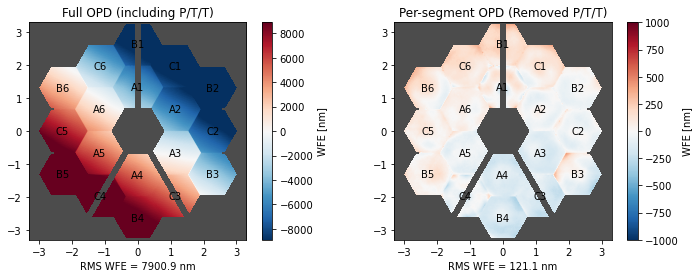

In [72]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [73]:
jitter = 0.0059    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # FP 5.9  mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning

instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library',
                           f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-21/output/gridded_psf_library/OTE-21-1158/Observation006/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-21/output/gridded_psf_library/OTE-21-1158/Observation006/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## obs 8

In [74]:
obs = 8

In [75]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-21/output/saved_states/ote_state_OTE-21_1158_Obs8_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    21.9836    -0.5967    -1.6338   364.4666  -300.1478     0.1651
A2	    -0.6957     1.7459    -1.5693  -104.1853    62.7415     0.2815
A3	   -34.1299     2.3452     2.2573  -101.8679   569.9164     0.1060
A4	   -25.0779     0.5469     4.7845   371.6188   398.5599    -0.0837
A5	    -3.6207    -1.7082     4.0928  -227.2394    54.1420     0.0345
A6	    14.8998    -2.3096     1.2791  -296.9655  -213.8277     0.2278
B1	   -75.0908     1.1038    -5.9414   178.1203 -1196.9810     0.2445
C1	    -0.2473    77.2225    -5.7903   -70.5283 -1199.8558     0.2508
B2	   -56.2926    -0.9432    -7.4671   -25.5233  -851

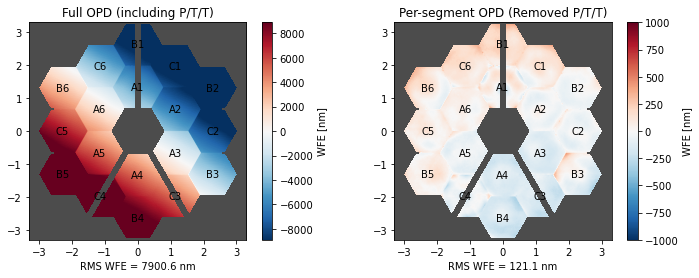

In [76]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [77]:
jitter = 0.0059    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # FP 5.9  mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning
                    
instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library', 
                           f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-21/output/gridded_psf_library/OTE-21-1158/Observation008/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-21/output/gridded_psf_library/OTE-21-1158/Observation008/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## OTE-22

In [78]:
OTEnumber = 'OTE-22'
prop_id = 1159
obs = 3

In [79]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-22/output/saved_states/ote_state_OTE-22_1159_Obs3_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    21.9821    -0.5967    -1.3442   364.4666  -300.1478     0.1644
A2	    -0.7004     1.7458    -0.6628  -104.1853    62.7415     0.2795
A3	   -34.1326     2.3452     2.7630  -101.8679   569.9164     0.1049
A4	   -25.0769     0.5469     4.6075   371.6188   398.5599    -0.0833
A5	    -3.6194    -1.7083     3.8320  -227.2394    54.1420     0.0351
A6	    14.9024    -2.3096     0.7832  -296.9655  -213.8277     0.2289
B1	   -75.0840     1.1038    -5.2711   178.1203 -1196.9810     0.2431
C1	    -0.2473    77.2164    -5.1032   -70.5283 -1199.8558     0.2493
B2	   -56.2761    -0.9432    -5.8143   -25.5233  -851

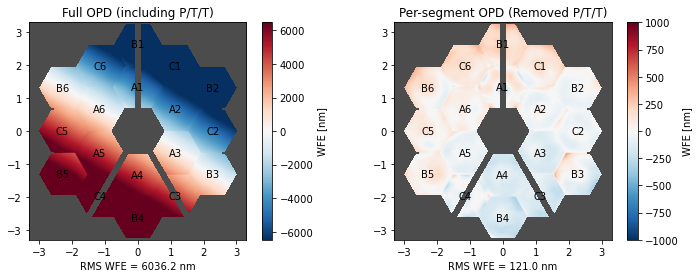

In [80]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [81]:
jitter = 0.0059    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # FP 5.9  mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning
                  # in the original notebook, a jitter of 0.020 was used, but I think this might be a mistake?
                     
instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library', 
                          f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-22/output/gridded_psf_library/OTE-22-1159/Observation003/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-22/output/gridded_psf_library/OTE-22-1159/Observation003/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## OTE-23

## obs 2 

In [85]:
OTEnumber = 'OTE-23'
prop_id = 1160
obs = 2

In [86]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-23/output/saved_states/ote_state_OTE-23_1160_Obs2_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    21.9836    -0.5983    -1.4979   364.4666  -300.1478     0.1644
A2	    -0.7061     1.7465    -0.6813  -104.1853    62.7415     0.2795
A3	   -34.1447     2.3414     2.5166  -101.8679   569.9164     0.1049
A4	   -25.0551     0.5333     4.7085   371.6188   398.5599    -0.0833
A5	    -3.6177    -1.7002     3.8990  -227.2394    54.1420     0.0351
A6	    14.8998    -2.3132     0.8020  -296.9655  -213.8277     0.2289
B1	   -75.0773     1.1022    -5.4620   178.1203 -1196.9810     0.2431
C1	    -0.2401    77.2209    -5.1544   -70.5283 -1199.8558     0.2493
B2	   -56.2794    -0.9464    -5.8274   -25.5233  -851

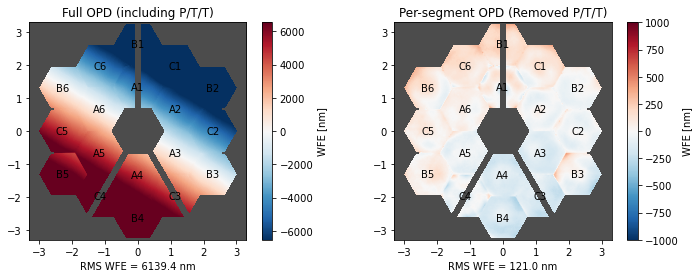

In [87]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [88]:
jitter = 0.0059    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # FP 5.9  mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning
                    
instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library',
                          f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-23/output/gridded_psf_library/OTE-23-1160/Observation002/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-23/output/gridded_psf_library/OTE-23-1160/Observation002/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits


## obs 4 


In [89]:
obs = 4

In [90]:
# Where to save MIRaGe outputs
out_dir = f'./{OTEnumber}/output'

Using /ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits as the input OPD
Loaded /ifs/jwst/tel/TeamPractices/OTE-23/output/saved_states/ote_state_OTE-23_1160_Obs4_final.txt
Segment poses in Control coordinates: (microns for decenter & piston, microradians for tilts and clocking):
  	      Xtilt      Ytilt     Piston   Clocking     Radial        ROC
A1	    22.0049    -0.6125    -1.4886   364.4666  -300.1478     0.1644
A2	    -0.6790     1.7353    -0.6802  -104.1853    62.7415     0.2795
A3	   -34.1329     2.3383     2.4964  -101.8679   569.9164     0.1049
A4	   -25.1099     0.5551     4.7044   371.6188   398.5599    -0.0833
A5	    -3.6621    -1.6991     3.9039  -227.2394    54.1420     0.0351
A6	    14.8870    -2.3147     0.8163  -296.9655  -213.8277     0.2289
B1	   -75.0214     1.1210    -5.4592   178.1203 -1196.9810     0.2431
C1	    -0.2368    77.2294    -5.1647   -70.5283 -1199.8558     0.2493
B2	   -56.2236    -0.9507    -5.8232   -25.5233  -851

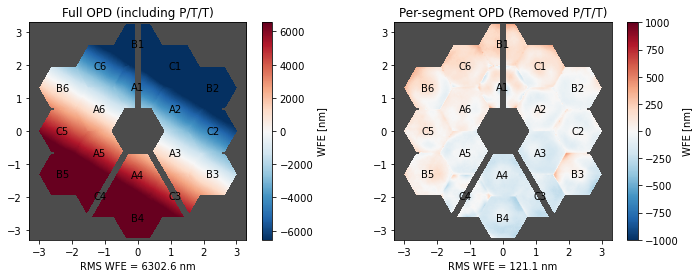

In [91]:
inputopd = "/ifs/jwst/tel/TeamPractices/OTE-19/output/saved_states/phase_post_ote19_residuals.fits"
ote = mirage_ote_utils.load_opd(inputopd, OTEnumber, prop_id, obs, npix=1024,
                                 input_dir=f"/ifs/jwst/tel/TeamPractices/{OTEnumber}/output/")

In [92]:
jitter = 0.0059    # arcseconds, radial. E.g. = 0.009 is 9 mas
                  # FP 5.9  mas
                  # 20 mas is the value appropriate for TRACK in GA
                  # See https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Performance+Expected+in+Commissioning
instrument='fgs'

fgs_filters = ['FGS']

num_psfs = 1 #9 

fov_pixels = 384    # big enough to just barely include the guide segment, to minimize Fourier aliasing at larger seps

lib = webbpsf.gridded_library.CreatePSFLibrary

fgs = webbpsf.Instrument(instrument)

fgs.detectors=['FGS1']

fgs.options['jitter'] = 'gaussian'
fgs.options['jitter_sigma'] = jitter

fgs.pupilopd = pupilopd # Not actually true, but needed to 
                         # pass MIRAGE's PSF matching check
fgs.pupil = ote          # Setting .pupil is sufficient to get the right OPD used
                         # even if we stick the default string into the pupilopd
                         # so it shows up in the FITS header
for filt in fgs_filters:
    psf_dir = os.path.join(out_dir, 'gridded_psf_library',
                           f"{OTEnumber}-{prop_id}/Observation00{obs}/Visit001/Activity01")

    os.makedirs(psf_dir, exist_ok = True)
    print(psf_dir)

    # large numbers of wavelengths are needed to accurately model partially-coherent PSFs.
    nlambda = 300

    grid = fgs.psf_grid(num_psfs=num_psfs, save=True, all_detectors=False,
                        use_detsampled_psf=False, fov_pixels=fov_pixels,
                        oversample=4, outdir=psf_dir, add_distortion=True,
                        nlambda=nlambda)  


./OTE-23/output/gridded_psf_library/OTE-23-1160/Observation004/Visit001/Activity01

Running instrument: FGS, filter: FGS
  Running detector: FGS1
    Position 1/1: (1023, 1023) pixels
  Saving file: ./OTE-23/output/gridded_psf_library/OTE-23-1160/Observation004/Visit001/Activity01/fgs_fgs1_fgs_fovp384_samp4_npsf1.fits
